# TELECOM CUSTOMER CHURN PREDICTION - DEEP LEARNING
# Student: Heven Tafese


In [51]:
import os
import json
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    classification_report,
)

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks

# Set random seeds for reproducibility
RANDOM_SEED = 42

In [28]:
churn_df = pd.read_csv("telecom_customer_churn.csv", encoding="latin1")
data_dict_df = pd.read_csv("telecom_data_dictionary.csv", encoding="latin1")
zip_pop_df = pd.read_csv("telecom_zipcode_population.csv", encoding="latin1")

# Check for matching zips
churn_zips = set(churn_df["Zip Code"].dropna())
pop_zips = set(zip_pop_df["Zip Code"].dropna())

# Merge population into churn data
churn_df = churn_df.merge(zip_pop_df, on="Zip Code", how="left")

print(f"\n Merge complete!")
print(f"   Shape before: (7043, 38)")
print(f"   Shape after: {churn_df.shape}")
print(f"   New column: Population ({'Population' in churn_df.columns})")

# Data Types & Missing Values
print("=" * 60)
print("DATA QUALITY")
print("=" * 60)
print("\nData Types:")
print(churn_df.dtypes.value_counts())

print("\nMissing Values:")
missing = churn_df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print(" No missing values!")

print(
    "\nNumerical features:",
    len(churn_df.select_dtypes(include=["float64", "int64"]).columns),
)
print("Categorical features:", len(churn_df.select_dtypes(include=["object"]).columns))
print(f"Main dataset shape: {churn_df.shape}")
churn_df.head()


 Merge complete!
   Shape before: (7043, 38)
   Shape after: (7043, 39)
   New column: Population (True)
DATA QUALITY

Data Types:
object     23
float64     9
int64       7
Name: count, dtype: int64

Missing Values:
Offer                                3877
Avg Monthly Long Distance Charges     682
Multiple Lines                        682
Internet Type                        1526
Avg Monthly GB Download              1526
Online Security                      1526
Online Backup                        1526
Device Protection Plan               1526
Premium Tech Support                 1526
Streaming TV                         1526
Streaming Movies                     1526
Streaming Music                      1526
Unlimited Data                       1526
Churn Category                       5174
Churn Reason                         5174
dtype: int64

Numerical features: 16
Categorical features: 23
Main dataset shape: (7043, 39)


,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason,Population
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN,4498
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN,31297
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices,62069
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction,46677
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability,42853


# Exploring the Dataset

In [52]:
target_col = "Customer Status"

print(f"Target variable: '{target_col}'")
print("\nUnique values:")
print(churn_df[target_col].value_counts())

# Create binary target (1 = Churned, 0 = Stayed/Joined)
churn_df["Churn"] = (churn_df[target_col] == "Churned").astype(int)

churn_rate = churn_df["Churn"].mean()
print(f"\n CHURN RATE: {churn_rate:.2%}")
print(f"   Churned: {churn_df['Churn'].sum()} customers")
print(f"   Retained: {(churn_df['Churn'] == 0).sum()} customers")
print(
    f"   Class Imbalance Ratio: {churn_df['Churn'].value_counts()[0] / churn_df['Churn'].value_counts()[1]:.1f}:1"
)

Target variable: 'Customer Status'

Unique values:
Customer Status
Stayed     4720
Churned    1869
Joined      454
Name: count, dtype: int64

 CHURN RATE: 26.54%
   Churned: 1869 customers
   Retained: 5174 customers
   Class Imbalance Ratio: 2.8:1


# Visualizations

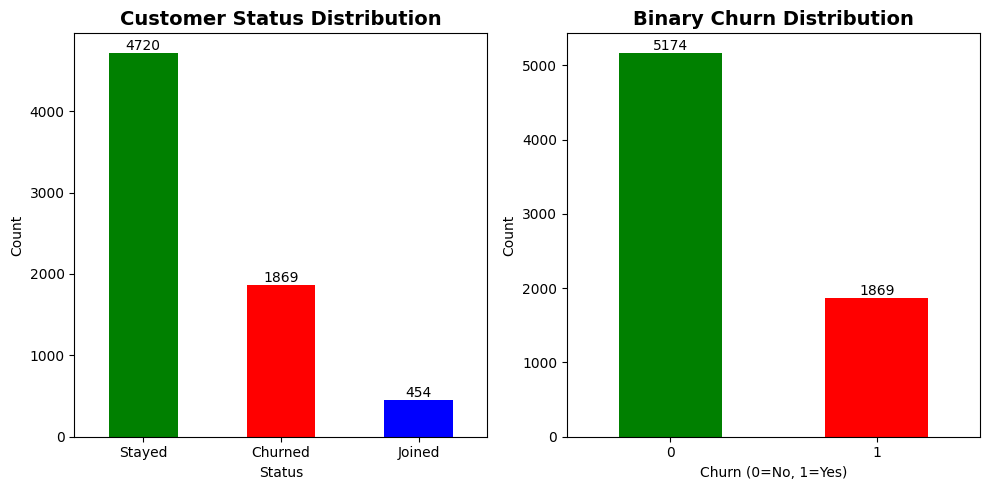

In [30]:
# Visualization of Target Variable Distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
churn_df["Customer Status"].value_counts().plot(
    kind="bar", color=["green", "red", "blue"]
)
plt.title("Customer Status Distribution", fontsize=14, fontweight="bold")
plt.xlabel("Status")
plt.ylabel("Count")
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
churn_binary = (churn_df["Customer Status"] == "Churned").astype(int)
churn_binary.value_counts().plot(kind="bar", color=["green", "red"])
plt.title("Binary Churn Distribution", fontsize=14, fontweight="bold")
plt.xlabel("Churn (0=No, 1=Yes)")
plt.ylabel("Count")
plt.xticks(rotation=0)

for ax in plt.gcf().axes:
    for container in ax.containers:
        ax.bar_label(container)

plt.tight_layout()
plt.show()

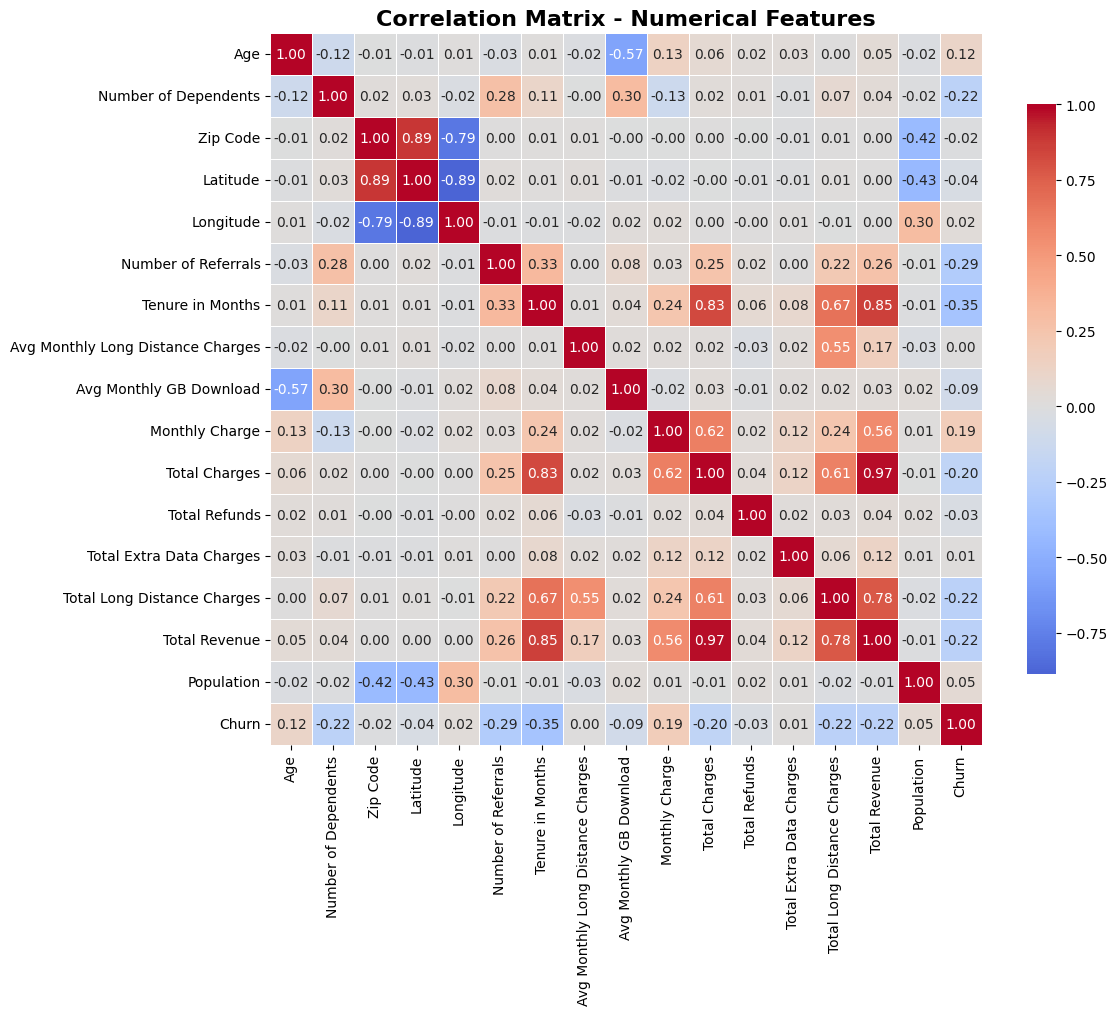


High Correlations (>0.8)
   Zip Code ↔ Latitude: 0.895
   Latitude ↔ Longitude: -0.886
   Tenure in Months ↔ Total Charges: 0.826
   Tenure in Months ↔ Total Revenue: 0.853
   Total Charges ↔ Total Revenue: 0.972


In [31]:
# Correlation Heatmap (Numerical Features Only)
numerical_cols = churn_df.select_dtypes(include=["float64", "int64"]).columns.tolist()

plt.figure(figsize=(12, 10))
correlation = churn_df[numerical_cols].corr()
sns.heatmap(
    correlation,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)
plt.title("Correlation Matrix - Numerical Features", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

high_corr = []
for i in range(len(correlation.columns)):
    for j in range(i + 1, len(correlation.columns)):
        if abs(correlation.iloc[i, j]) > 0.8:
            high_corr.append(
                (correlation.columns[i], correlation.columns[j], correlation.iloc[i, j])
            )

if high_corr:
    print("\nHigh Correlations (>0.8)")
    for feat1, feat2, corr_val in high_corr:
        print(f"   {feat1} ↔ {feat2}: {corr_val:.3f}")

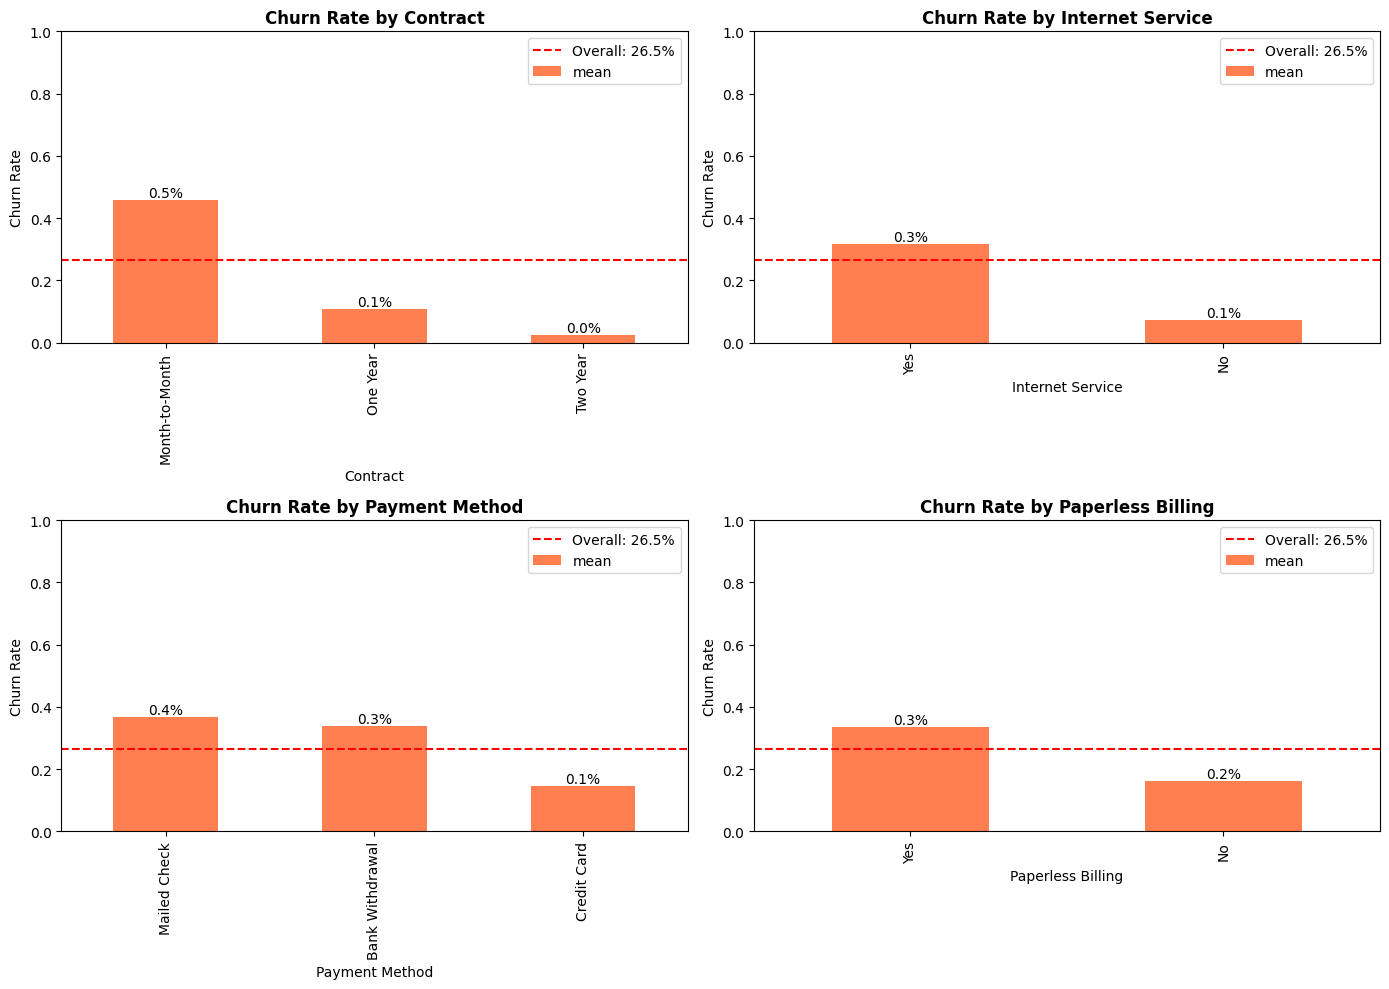

In [32]:
churn_binary = (churn_df["Customer Status"] == "Churned").astype(int)
df_viz = churn_df.copy()
df_viz["Churn"] = churn_binary

categorical_features = [
    "Contract",
    "Internet Service",
    "Payment Method",
    "Paperless Billing",
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for i, col in enumerate(categorical_features):
    if col in df_viz.columns:
        churn_rate_by_cat = df_viz.groupby(col)["Churn"].agg(["mean", "count"])
        churn_rate_by_cat = churn_rate_by_cat.sort_values("mean", ascending=False)

        churn_rate_by_cat["mean"].plot(kind="bar", ax=axes[i], color="coral")
        axes[i].set_title(f"Churn Rate by {col}", fontsize=12, fontweight="bold")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Churn Rate")
        axes[i].set_ylim(0, 1)
        axes[i].axhline(
            y=churn_binary.mean(),
            color="red",
            linestyle="--",
            label=f"Overall: {churn_binary.mean():.1%}",
        )
        axes[i].legend()

        for container in axes[i].containers:
            axes[i].bar_label(container, fmt="%.1f%%", label_type="edge")

plt.tight_layout()
plt.show()

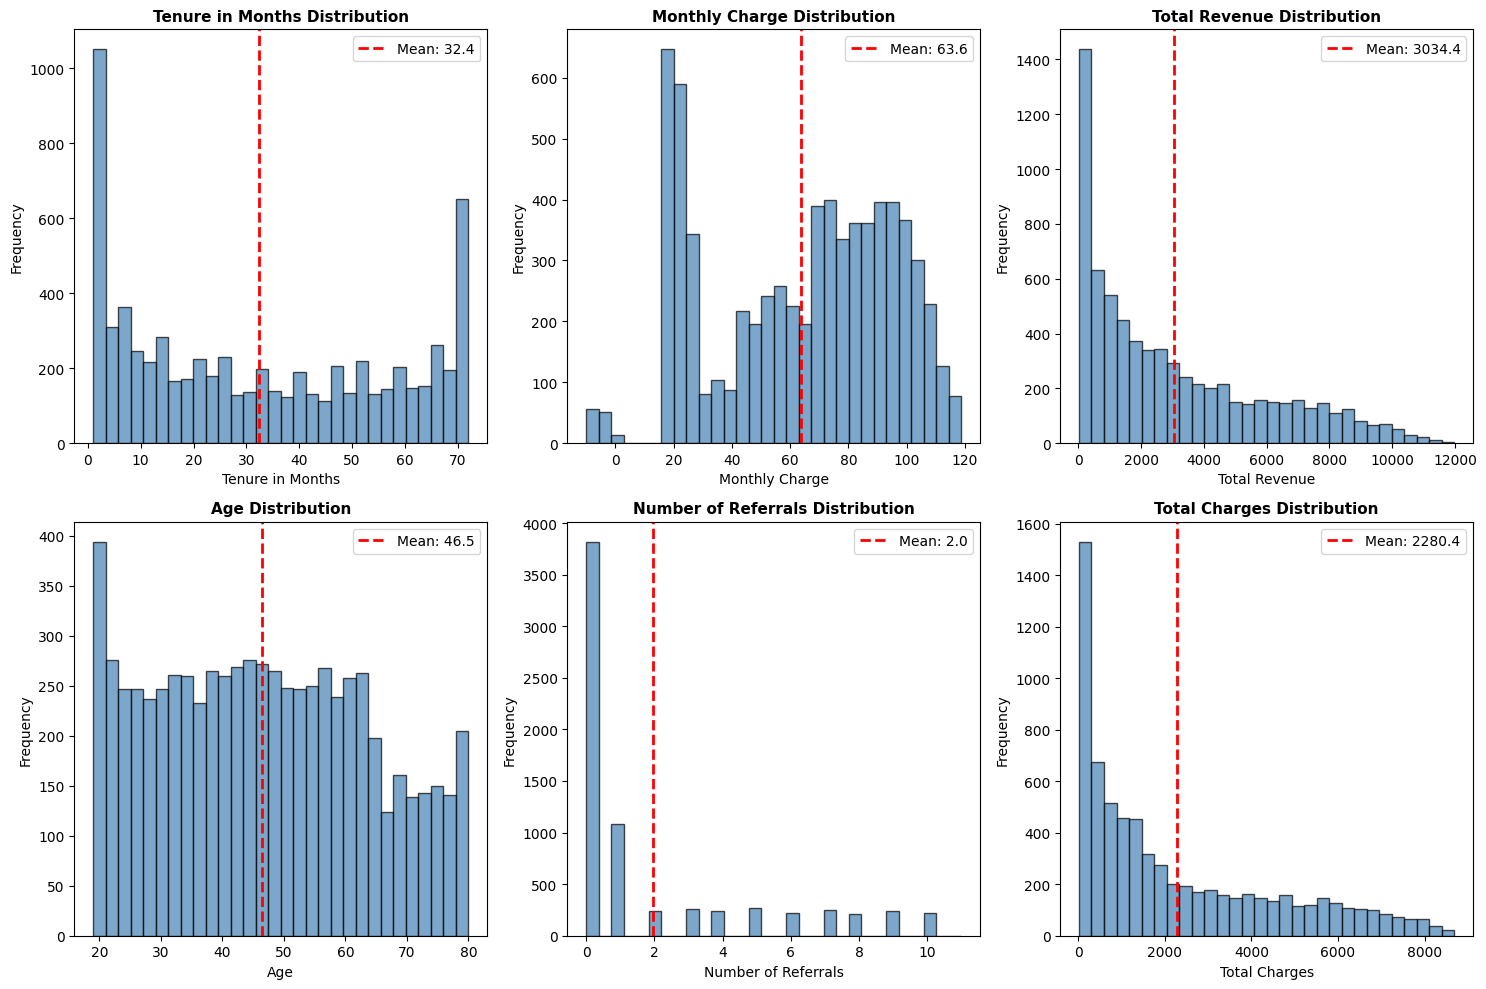

In [33]:
# Distribution of Key Numerical Features
key_numerical = [
    "Tenure in Months",
    "Monthly Charge",
    "Total Revenue",
    "Age",
    "Number of Referrals",
    "Total Charges",
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(key_numerical):
    if col in churn_df.columns:
        axes[i].hist(
            churn_df[col].dropna(),
            bins=30,
            edgecolor="black",
            alpha=0.7,
            color="steelblue",
        )
        axes[i].set_title(f"{col} Distribution", fontsize=11, fontweight="bold")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Frequency")
        axes[i].axvline(
            churn_df[col].mean(),
            color="red",
            linestyle="--",
            linewidth=2,
            label=f"Mean: {churn_df[col].mean():.1f}",
        )
        axes[i].legend()

plt.tight_layout()
plt.show()

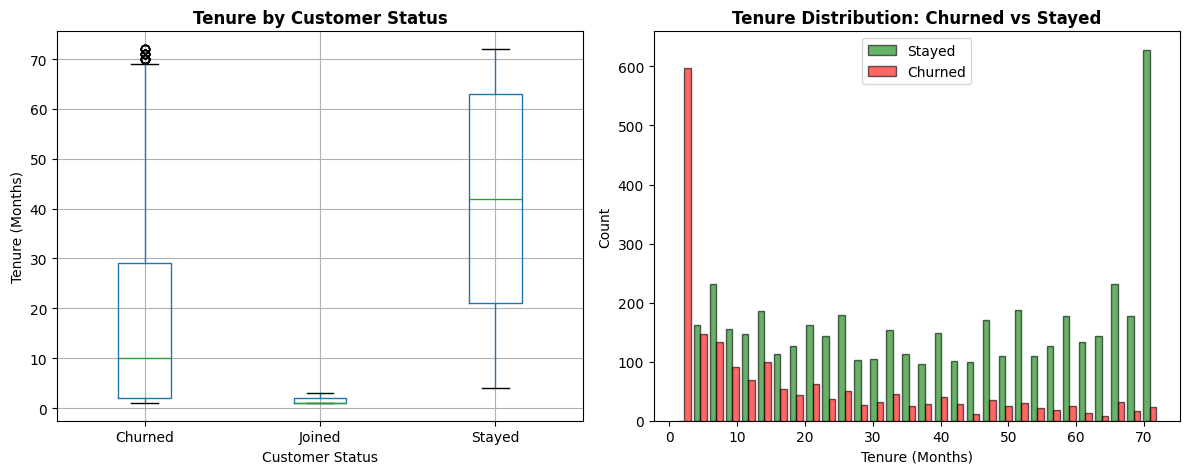

Average Tenure - Churned: 18.0 months
Average Tenure - Stayed: 41.0 months
Difference: 23.1 months


In [34]:
# Churn vs Tenure (Critical Business Insight!)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
churn_df.boxplot(column="Tenure in Months", by="Customer Status", ax=plt.gca())
plt.title("Tenure by Customer Status", fontsize=12, fontweight="bold")
plt.suptitle("")
plt.xlabel("Customer Status")
plt.ylabel("Tenure (Months)")

plt.subplot(1, 2, 2)
churned = churn_df[churn_df["Customer Status"] == "Churned"]["Tenure in Months"]
stayed = churn_df[churn_df["Customer Status"] == "Stayed"]["Tenure in Months"]

plt.hist(
    [stayed, churned],
    bins=30,
    label=["Stayed", "Churned"],
    color=["green", "red"],
    alpha=0.6,
    edgecolor="black",
)
plt.title("Tenure Distribution: Churned vs Stayed", fontsize=12, fontweight="bold")
plt.xlabel("Tenure (Months)")
plt.ylabel("Count")
plt.legend()

plt.tight_layout()
plt.show()

print(f"Average Tenure - Churned: {churned.mean():.1f} months")
print(f"Average Tenure - Stayed: {stayed.mean():.1f} months")
print(f"Difference: {stayed.mean() - churned.mean():.1f} months")

# Preprocessing

In [35]:
# Copy dataset
df_clean = churn_df.copy()

# Columns to drop
cols_to_drop = [
    "Customer ID",
    "Customer Status",
    "Churn Category",
    "Churn Reason",
    "Zip Code",
    "City",
    "Total Revenue",
]
df_clean = df_clean.drop(columns=cols_to_drop)

# Missing values check
print(f"\n Missing values BEFORE: {df_clean.isnull().sum().sum()}")

df_clean["Offer"] = df_clean["Offer"].fillna("No Offer")

internet_cols = [
    "Internet Type",
    "Online Security",
    "Online Backup",
    "Device Protection Plan",
    "Premium Tech Support",
    "Streaming TV",
    "Streaming Movies",
    "Streaming Music",
    "Unlimited Data",
]

# Fill internet-related columns
existing_internet_cols = [c for c in internet_cols if c in df_clean.columns]
df_clean[existing_internet_cols] = df_clean[existing_internet_cols].fillna(
    "No Internet"
)

# Other numeric/categorical fills
if "Avg Monthly GB Download" in df_clean.columns:
    df_clean["Avg Monthly GB Download"] = df_clean["Avg Monthly GB Download"].fillna(0)

if "Multiple Lines" in df_clean.columns:
    df_clean["Multiple Lines"] = df_clean["Multiple Lines"].fillna("No Phone Service")

if "Avg Monthly Long Distance Charges" in df_clean.columns:
    df_clean["Avg Monthly Long Distance Charges"] = df_clean[
        "Avg Monthly Long Distance Charges"
    ].fillna(0)

print(f" Missing values AFTER: {df_clean.isnull().sum().sum()}")

# Encode categorical columns using Label Encoding
categorical_cols = df_clean.select_dtypes(include=["object"]).columns.tolist()

print(f"\n Encoding {len(categorical_cols)} categorical features...")

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))
    label_encoders[col] = le

# Separate features/target
X = df_clean.drop("Churn", axis=1)
y = df_clean["Churn"]

print(f"\n Dataset ready:")
print(f"   Total samples: {X.shape[0]}")
print(f"   Total features: {X.shape[1]}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

print(f"\n Train/Test Split:")
print(f"   Training: {X_train.shape[0]} samples")
print(f"   Testing: {X_test.shape[0]} samples")

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(" StandardScaler applied")

# Class weights
class_weights = class_weight.compute_class_weight(
    "balanced", classes=np.unique(y_train), y=y_train
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"\n Class weights:")
print(f"   Retained (0): {class_weight_dict[0]:.2f}")
print(f"   Churned (1): {class_weight_dict[1]:.2f}")


 Missing values BEFORE: 20501
 Missing values AFTER: 0

 Encoding 18 categorical features...

 Dataset ready:
   Total samples: 7043
   Total features: 32

 Train/Test Split:
   Training: 5634 samples
   Testing: 1409 samples
 StandardScaler applied

 Class weights:
   Retained (0): 0.68
   Churned (1): 1.88


# Deep Learning

In [36]:
# Build Model 1 - Baseline Architecture
model_1 = models.Sequential(
    [
        layers.Dense(64, activation="relu", input_shape=(32,), name="hidden_1"),
        layers.Dense(32, activation="relu", name="hidden_2"),
        layers.Dense(16, activation="relu", name="hidden_3"),
        layers.Dense(1, activation="sigmoid", name="output"),
    ],
    name="Model_1_Baseline",
)
model_1.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Model_1_Baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,737 (18.50 KB)

 Trainable params: 4,737 (18.50 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Compile Model 1
model_1.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Recall(name="recall")],
)

In [38]:
# Setup callbacks
early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True, verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, min_lr=1e-7, verbose=1
)

In [39]:
# Train Model 1
history_1 = model_1.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1,
)

Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6442 - loss: 0.5806 - recall: 0.8388 - val_accuracy: 0.7746 - val_loss: 0.4482 - val_recall: 0.7864 - learning_rate: 0.0010
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7827 - loss: 0.4337 - recall: 0.8488 - val_accuracy: 0.8048 - val_loss: 0.4162 - val_recall: 0.8407 - learning_rate: 0.0010
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8041 - loss: 0.4020 - recall: 0.8402 - val_accuracy: 0.7640 - val_loss: 0.4917 - val_recall: 0.8983 - learning_rate: 0.0010
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8071 - loss: 0.3860 - recall: 0.8786 - val_accuracy: 0.8154 - val_loss: 0.3950 - val_recall: 0.8305 - learning_rate: 0.0010
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8111 - loss: 0.3795 - recall: 0.8593 - val_accuracy: 0.8163 - val_loss: 0.4074 - val_recall: 0.8508 - learning_rate: 0.0010
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3

In [40]:
# Build Model 2 - Dropout Regularization
model_2 = models.Sequential(
    [
        layers.Dense(128, activation="relu", input_shape=(32,), name="hidden_1"),
        layers.Dropout(0.3, name="dropout_1"),
        layers.Dense(64, activation="relu", name="hidden_2"),
        layers.Dropout(0.2, name="dropout_2"),
        layers.Dense(32, activation="relu", name="hidden_3"),
        layers.Dropout(0.2, name="dropout_3"),
        layers.Dense(16, activation="relu", name="hidden_4"),
        layers.Dense(1, activation="sigmoid", name="output"),
    ],
    name="Model_2_Dropout",
)
model_2.summary()

Model: "Model_2_Dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_4 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,105 (59.00 KB)

 Trainable params: 15,105 (59.00 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Compile Model 2
model_2.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Recall(name="recall")],
)

In [42]:
# Train Model 2
history_2 = model_2.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1,
)

Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6964 - loss: 0.6166 - recall: 0.6102 - val_accuracy: 0.7471 - val_loss: 0.4883 - val_recall: 0.8644 - learning_rate: 0.0010
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7606 - loss: 0.4668 - recall: 0.8322 - val_accuracy: 0.7693 - val_loss: 0.4515 - val_recall: 0.8237 - learning_rate: 0.0010
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7802 - loss: 0.4621 - recall: 0.8265 - val_accuracy: 0.7950 - val_loss: 0.4196 - val_recall: 0.8203 - learning_rate: 0.0010
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8037 - loss: 0.4163 - recall: 0.8539 - val_accuracy: 0.7862 - val_loss: 0.4239 - val_recall: 0.8441 - learning_rate: 0.0010
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8009 - loss: 0.4091 - recall: 0.8402 - val_accuracy: 0.7941 - val_loss: 0.4007 - val_recall: 0.8237 - learning_rate: 0.0010
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4

In [43]:
# Build Model 3 - Batch Normalization
model_3 = models.Sequential(
    [
        layers.Dense(64, activation="relu", input_shape=(32,), name="hidden_1"),
        layers.BatchNormalization(name="batch_norm_1"),
        layers.Dense(32, activation="relu", name="hidden_2"),
        layers.BatchNormalization(name="batch_norm_2"),
        layers.Dense(16, activation="relu", name="hidden_3"),
        layers.Dense(1, activation="sigmoid", name="output"),
    ],
    name="Model_3_BatchNorm",
)
model_3.summary()

Model: "Model_3_BatchNorm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,121 (20.00 KB)

 Trainable params: 4,929 (19.25 KB)

 Non-trainable params: 192 (768.00 B)

In [44]:
# Compile Model 3
model_3.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Recall(name="recall")],
)

In [45]:
# Train Model 3
history_3 = model_3.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1,
)

Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6609 - loss: 0.5916 - recall: 0.7281 - val_accuracy: 0.7640 - val_loss: 0.4949 - val_recall: 0.8441 - learning_rate: 0.0010
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7841 - loss: 0.4326 - recall: 0.8368 - val_accuracy: 0.7773 - val_loss: 0.4547 - val_recall: 0.8610 - learning_rate: 0.0010
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7936 - loss: 0.4127 - recall: 0.8418 - val_accuracy: 0.7906 - val_loss: 0.4389 - val_recall: 0.8508 - learning_rate: 0.0010
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8085 - loss: 0.3857 - recall: 0.8817 - val_accuracy: 0.8030 - val_loss: 0.4025 - val_recall: 0.8136 - learning_rate: 0.0010
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8315 - loss: 0.3543 - recall: 0.8685 - val_accuracy: 0.8092 - val_loss: 0.4030 - val_recall: 0.8305 - learning_rate: 0.0010
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4

# Testing Data

In [46]:
# Generate Predictions for All Models
y_pred_proba_1 = model_1.predict(X_test_scaled, verbose=0)
y_pred_proba_2 = model_2.predict(X_test_scaled, verbose=0)
y_pred_proba_3 = model_3.predict(X_test_scaled, verbose=0)

# Convert to binary predictions (threshold = 0.5)
y_pred_1 = (y_pred_proba_1 > 0.5).astype(int).flatten()
y_pred_2 = (y_pred_proba_2 > 0.5).astype(int).flatten()
y_pred_3 = (y_pred_proba_3 > 0.5).astype(int).flatten()

Best epochs found:
  Model 1: Epoch 6
  Model 2: Epoch 8
  Model 3: Epoch 10


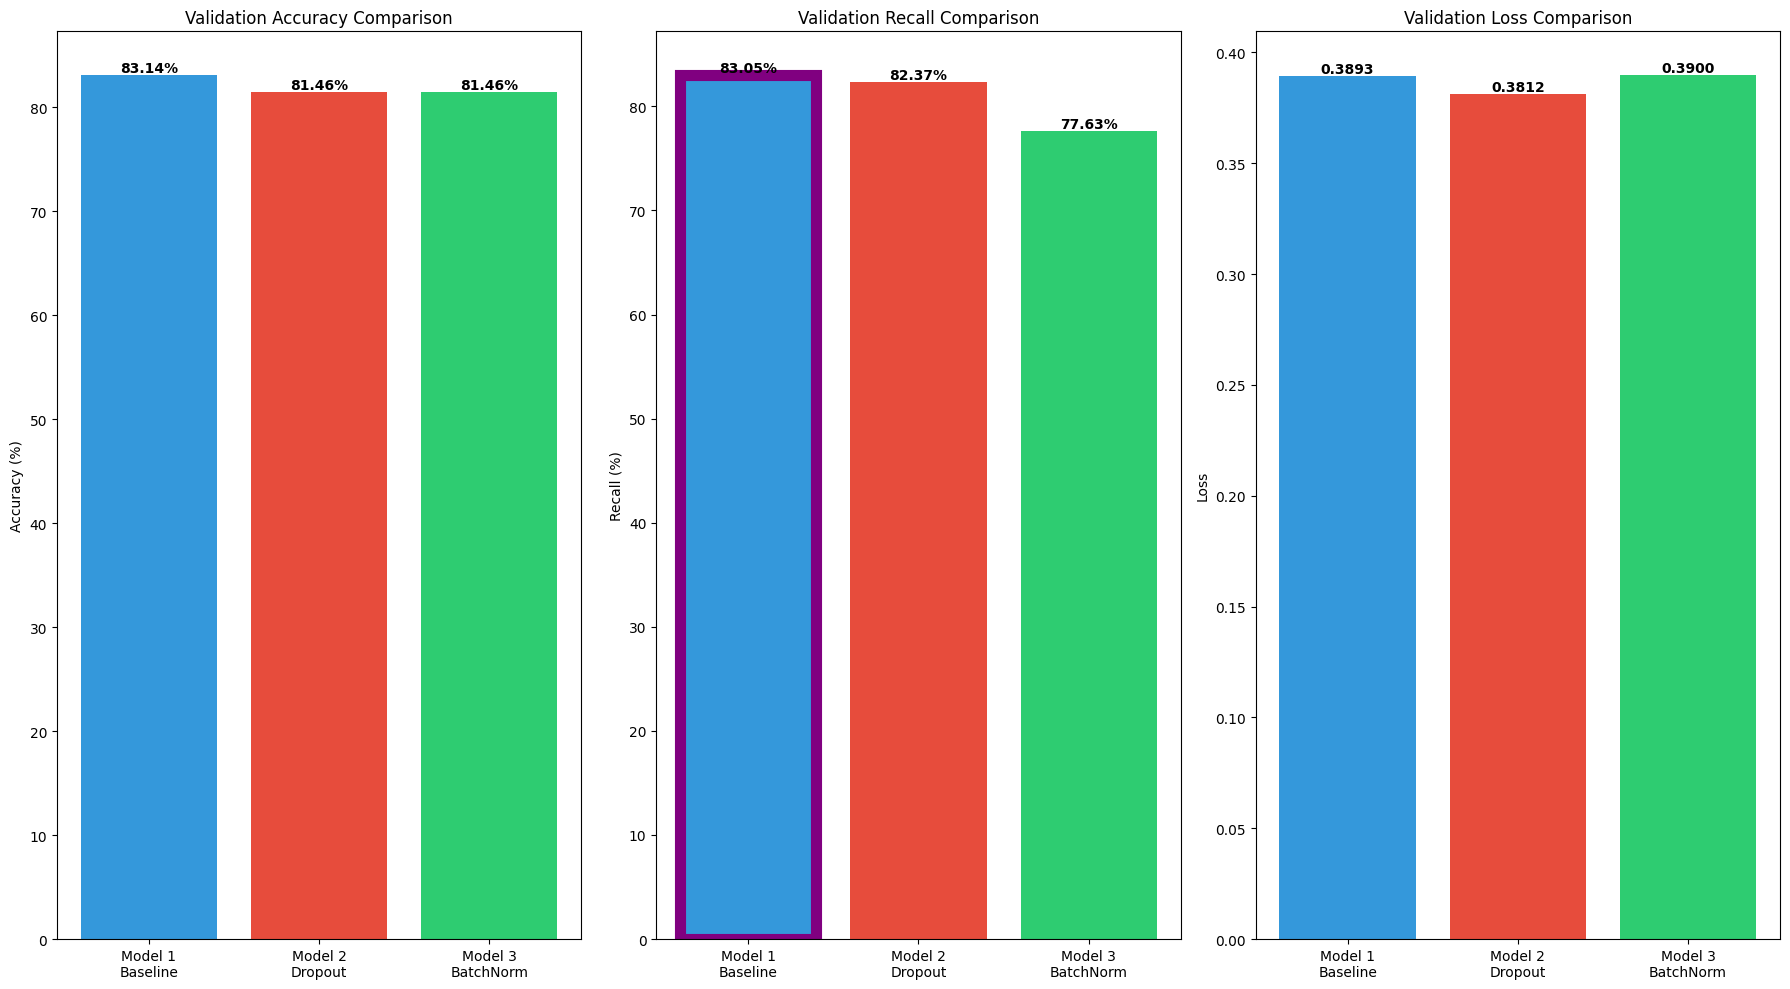

In [47]:
# Compare All 3 Models
fig, axes = plt.subplots(1, 3, figsize=(18, 10))

best_epoch_1 = np.argmin(history_1.history["val_loss"])
best_epoch_2 = np.argmin(history_2.history["val_loss"])
best_epoch_3 = np.argmin(history_3.history["val_loss"])

print(f"Best epochs found:")
print(f"  Model 1: Epoch {best_epoch_1 + 1}")
print(f"  Model 2: Epoch {best_epoch_2 + 1}")
print(f"  Model 3: Epoch {best_epoch_3 + 1}")

models_performance = {
    "Model 1\nBaseline": {
        "accuracy": history_1.history["val_accuracy"][best_epoch_1],
        "recall": history_1.history["val_recall"][best_epoch_1],
        "loss": history_1.history["val_loss"][best_epoch_1],
    },
    "Model 2\nDropout": {
        "accuracy": history_2.history["val_accuracy"][best_epoch_2],
        "recall": history_2.history["val_recall"][best_epoch_2],
        "loss": history_2.history["val_loss"][best_epoch_2],
    },
    "Model 3\nBatchNorm": {
        "accuracy": history_3.history["val_accuracy"][best_epoch_3],
        "recall": history_3.history["val_recall"][best_epoch_3],
        "loss": history_3.history["val_loss"][best_epoch_3],
    },
}

models = list(models_performance.keys())
colors = ["#3498db", "#e74c3c", "#2ecc71"]

# Accuracy Comparison
accuracies = [models_performance[m]["accuracy"] * 100 for m in models]
bars1 = axes[0].bar(models, accuracies, color=colors)
axes[0].set_title("Validation Accuracy Comparison")
axes[0].set_ylabel("Accuracy (%)")
for i, bar in enumerate(bars1):
    height = bar.get_height()
    axes[0].text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:.2f}%",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

# Recall Comparison
recalls = [models_performance[m]["recall"] * 100 for m in models]
bars2 = axes[1].bar(models, recalls, color=colors)
axes[1].set_title("Validation Recall Comparison")
axes[1].set_ylabel("Recall (%)")
for i, bar in enumerate(bars2):
    height = bar.get_height()
    axes[1].text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:.2f}%",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

# Highlight best recall
max_recall_idx = recalls.index(max(recalls))
bars2[max_recall_idx].set_edgecolor("purple")
bars2[max_recall_idx].set_linewidth(8)


# Loss Comparison
losses = [models_performance[m]["loss"] for m in models]
bars3 = axes[2].bar(models, losses, color=colors)
axes[2].set_title("Validation Loss Comparison")
axes[2].set_ylabel("Loss")
for i, bar in enumerate(bars3):
    height = bar.get_height()
    axes[2].text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:.4f}",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

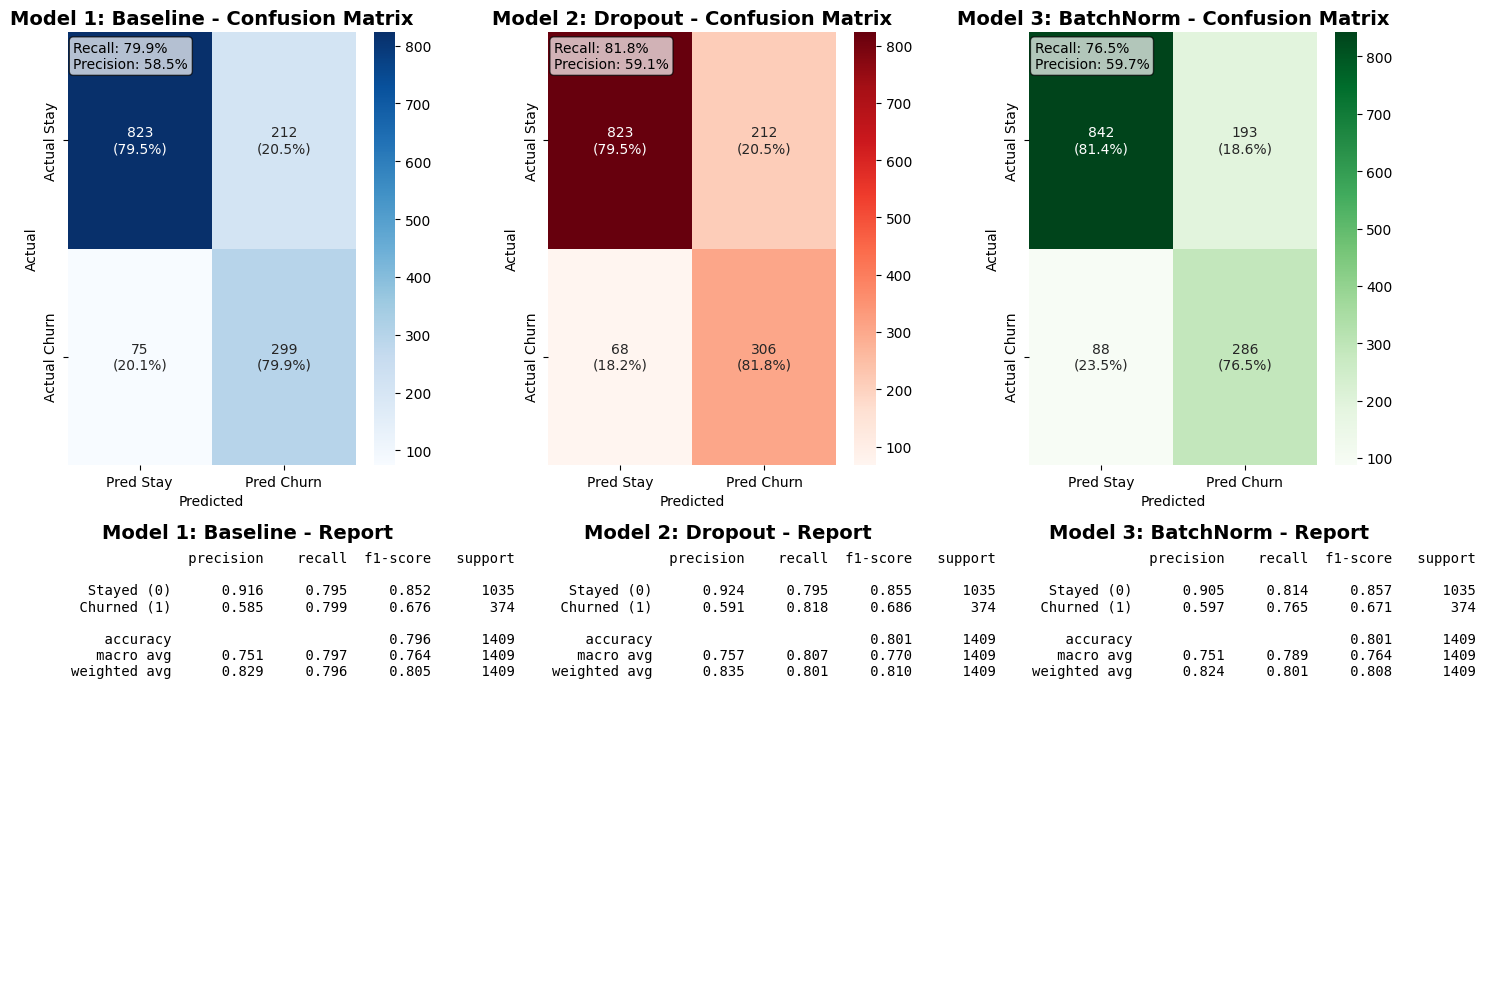

In [48]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

models_preds = [
    (y_pred_1, "Model 1: Baseline", "Blues"),
    (y_pred_2, "Model 2: Dropout", "Reds"),
    (y_pred_3, "Model 3: BatchNorm", "Greens"),
]

for idx, (y_pred, title, cmap) in enumerate(models_preds):
    # ------------------------------
    # Top row: Confusion Matrix
    # ------------------------------
    cm = confusion_matrix(y_test, y_pred)
    cm_percent = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100
    annotations = [
        [f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)" for j in range(2)] for i in range(2)
    ]

    sns.heatmap(
        cm,
        annot=annotations,
        fmt="",
        cmap=cmap,
        cbar=True,
        ax=axes[0, idx],
        xticklabels=["Pred Stay", "Pred Churn"],
        yticklabels=["Actual Stay", "Actual Churn"],
    )
    axes[0, idx].set_title(
        title + " - Confusion Matrix", fontsize=14, fontweight="bold"
    )
    axes[0, idx].set_ylabel("Actual")
    axes[0, idx].set_xlabel("Predicted")

    # Add Recall/Precision box
    tn, fp, fn, tp = cm.ravel()
    recall = tp / (tp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    metrics_text = f"Recall: {recall * 100:.1f}%\nPrecision: {precision * 100:.1f}%"
    axes[0, idx].text(
        0.02,
        0.98,
        metrics_text,
        transform=axes[0, idx].transAxes,
        fontsize=10,
        va="top",
        bbox=dict(boxstyle="round", fc="white", alpha=0.7),
    )

    # ------------------------------
    # Bottom row: Classification Report
    # ------------------------------
    report_text = classification_report(
        y_test, y_pred, target_names=["Stayed (0)", "Churned (1)"], digits=3
    )
    axes[1, idx].text(
        0.01, 0.99, report_text, fontsize=10, va="top", family="monospace"
    )
    axes[1, idx].axis("off")
    axes[1, idx].set_title(title + " - Report", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

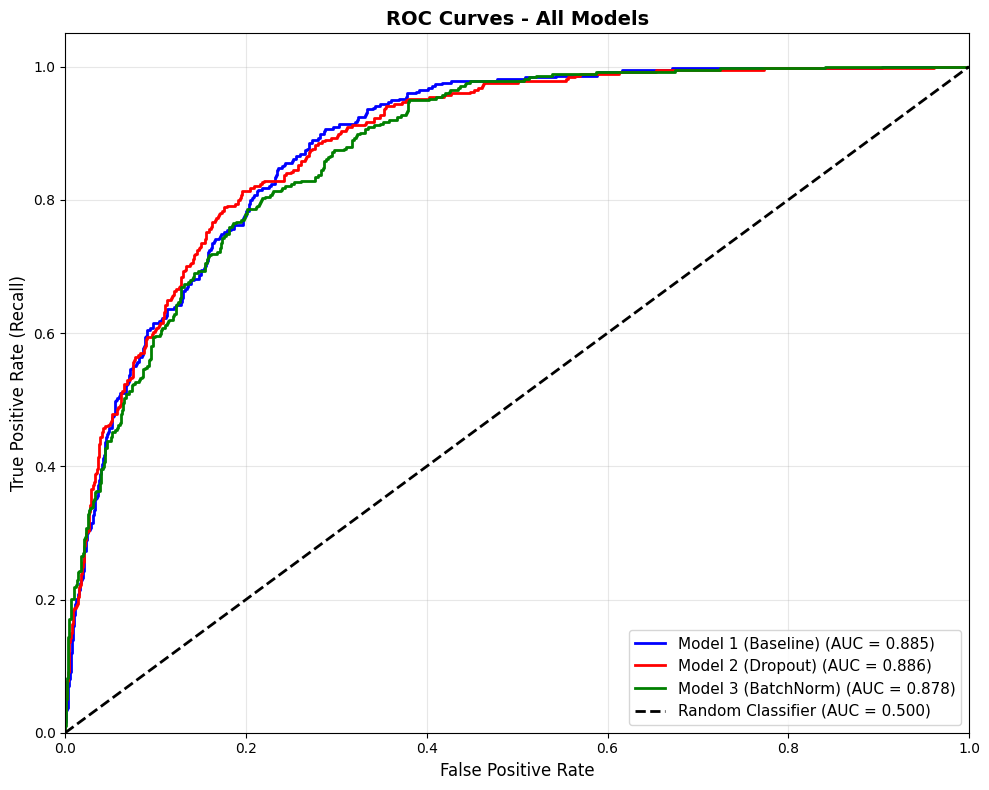

In [49]:
# ROC Curves for All Models
fig, ax = plt.subplots(figsize=(10, 8))

models_roc = [
    (y_pred_proba_1, "Model 1 (Baseline)", "blue"),
    (y_pred_proba_2, "Model 2 (Dropout)", "red"),
    (y_pred_proba_3, "Model 3 (BatchNorm)", "green"),
]

for y_pred_proba, label, color in models_roc:
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, color=color, linewidth=2, label=f"{label} (AUC = {roc_auc:.3f})")

# Plot diagonal (random classifier)
ax.plot([0, 1], [0, 1], "k--", linewidth=2, label="Random Classifier (AUC = 0.500)")

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate (Recall)", fontsize=12)
ax.set_title("ROC Curves - All Models", fontsize=14, fontweight="bold")
ax.legend(loc="lower right", fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [50]:
test_loss_1, test_acc_1, test_recall_1 = model_1.evaluate(
    X_test_scaled, y_test, verbose=0
)
test_loss_2, test_acc_2, test_recall_2 = model_2.evaluate(
    X_test_scaled, y_test, verbose=0
)
test_loss_3, test_acc_3, test_recall_3 = model_3.evaluate(
    X_test_scaled, y_test, verbose=0
)

test_results = {
    "Model 1": {
        "accuracy": test_acc_1,
        "recall": test_recall_1,
        "loss": test_loss_1,
        "model": model_1,
        "history": history_1,
        "best_epoch": best_epoch_1,
    },
    "Model 2": {
        "accuracy": test_acc_2,
        "recall": test_recall_2,
        "loss": test_loss_2,
        "model": model_2,
        "history": history_2,
        "best_epoch": best_epoch_2,
    },
    "Model 3": {
        "accuracy": test_acc_3,
        "recall": test_recall_3,
        "loss": test_loss_3,
        "model": model_3,
        "history": history_3,
        "best_epoch": best_epoch_3,
    },
}


# CALCULATE  METRICS
def calculate_business_metrics(y_true, y_pred, model_name="Model"):
    """Calculate all metrics from predictions - SINGLE SOURCE OF TRUTH"""

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    total_customers = len(y_true)
    total_churners = int(y_true.sum())
    total_retained = total_customers - total_churners
    churn_rate = total_churners / total_customers

    avg_monthly_charge = 64.76
    customer_lifetime_months = 24
    clv = avg_monthly_charge * customer_lifetime_months
    retention_cost = 70

    churners_caught = tp
    churners_missed = fn
    offers_sent = tp + fp
    revenue_saved = tp * clv
    revenue_lost = fn * clv
    campaign_cost = offers_sent * retention_cost
    net_benefit = revenue_saved - campaign_cost
    roi = (net_benefit / campaign_cost * 100) if campaign_cost > 0 else 0
    cost_per_customer_saved = campaign_cost / tp if tp > 0 else float("inf")
    revenue_per_dollar_spent = revenue_saved / campaign_cost if campaign_cost > 0 else 0

    return {
        "model_name": model_name,
        "true_negatives": int(tn),
        "false_positives": int(fp),
        "false_negatives": int(fn),
        "true_positives": int(tp),
        "accuracy": float(accuracy),
        "recall": float(recall),
        "precision": float(precision),
        "f1_score": float(f1),
        "specificity": float(specificity),
        "total_customers": int(total_customers),
        "total_churners": int(total_churners),
        "total_retained": int(total_retained),
        "churn_rate": float(churn_rate),
        "clv": float(clv),
        "retention_cost": float(retention_cost),
        "avg_monthly_charge": float(avg_monthly_charge),
        "customer_lifetime_months": int(customer_lifetime_months),
        "churners_caught": int(churners_caught),
        "churners_missed": int(churners_missed),
        "offers_sent": int(offers_sent),
        "revenue_saved": float(revenue_saved),
        "revenue_lost": float(revenue_lost),
        "campaign_cost": float(campaign_cost),
        "net_benefit": float(net_benefit),
        "roi": float(roi),
        "cost_per_customer_saved": float(cost_per_customer_saved),
        "revenue_per_dollar_spent": float(revenue_per_dollar_spent),
        "assumptions": {
            "clv_calculation": f"{avg_monthly_charge:.2f} per month × {customer_lifetime_months} months",
            "retention_cost_source": "Industry standard for telecom retention campaigns",
            "success_rate": "100% (assumes all caught churners accept offer)",
            "data_source": "Test set predictions from trained model",
        },
    }


#  CALCULATE METRICS FOR ALL MODELS (using predictions from earlier cell)
metrics_model_1 = calculate_business_metrics(y_test, y_pred_1, "Model 1 (Baseline)")
metrics_model_2 = calculate_business_metrics(y_test, y_pred_2, "Model 2 (Dropout)")
metrics_model_3 = calculate_business_metrics(y_test, y_pred_3, "Model 3 (BatchNorm)")

#  DETERMINE WINNER
models = [
    ("Model 1 (Baseline)", metrics_model_1),
    ("Model 2 (Dropout)", metrics_model_2),
    ("Model 3 (BatchNorm)", metrics_model_3),
]

winner_name, winner_metrics = max(models, key=lambda x: x[1]["recall"])
winner_idx = [name for name, _ in models].index(winner_name)
winner_models = [model_1, model_2, model_3]
selected_model = winner_models[winner_idx]

#  SAVE ALL ARTIFACTS

os.makedirs("models", exist_ok=True)

selected_model.save("models/churn_model_baseline.keras")

preprocessing_objects = {
    "scaler": scaler,
    "label_encoders": label_encoders,
    "feature_names": list(X.columns),
    "class_weights": class_weight_dict,
    "input_shape": (32,),
    "selected_model_name": winner_name,
}

with open("models/preprocessing.pkl", "wb") as f:
    pickle.dump(preprocessing_objects, f)

training_summary = {
    "model_1": {
        "val_accuracy": float(history_1.history["val_accuracy"][best_epoch_1]),
        "val_recall": float(history_1.history["val_recall"][best_epoch_1]),
        "val_loss": float(history_1.history["val_loss"][best_epoch_1]),
        "test_accuracy": float(test_acc_1),
        "test_recall": float(test_recall_1),
        "test_loss": float(test_loss_1),
        "best_epoch": int(best_epoch_1) + 1,
        "total_params": int(model_1.count_params()),
    },
    "model_2": {
        "val_accuracy": float(history_2.history["val_accuracy"][best_epoch_2]),
        "val_recall": float(history_2.history["val_recall"][best_epoch_2]),
        "val_loss": float(history_2.history["val_loss"][best_epoch_2]),
        "test_accuracy": float(test_acc_2),
        "test_recall": float(test_recall_2),
        "test_loss": float(test_loss_2),
        "best_epoch": int(best_epoch_2) + 1,
        "total_params": int(model_2.count_params()),
    },
    "model_3": {
        "val_accuracy": float(history_3.history["val_accuracy"][best_epoch_3]),
        "val_recall": float(history_3.history["val_recall"][best_epoch_3]),
        "val_loss": float(history_3.history["val_loss"][best_epoch_3]),
        "test_accuracy": float(test_acc_3),
        "test_recall": float(test_recall_3),
        "test_loss": float(test_loss_3),
        "best_epoch": int(best_epoch_3) + 1,
        "total_params": int(model_3.count_params()),
    },
    "selected_model": winner_name,
}

with open("models/training_summary.json", "w") as f:
    json.dump(training_summary, f, indent=4)

all_metrics = {
    "model_1": metrics_model_1,
    "model_2": metrics_model_2,
    "model_3": metrics_model_3,
    "selected_model": winner_name,
    "selection_criteria": "highest_recall",
    "timestamp": pd.Timestamp.now().isoformat(),
    "data_source": "Test set predictions",
    "test_set_size": int(len(y_test)),
    "random_seed": RANDOM_SEED if "RANDOM_SEED" in locals() else None,
}

with open("models/metrics.json", "w") as f:
    json.dump(all_metrics, f, indent=4)

# =============================================================================
# SUMMARY OUTPUT
# =============================================================================

print("=" * 70)
print("MODEL EVALUATION COMPLETE")
print("=" * 70)
print(f"Winner: {winner_name}")
print(f"Recall: {winner_metrics['recall']:.2%}")
print(f"Accuracy: {winner_metrics['accuracy']:.2%}")
print(f"Net Benefit: £{winner_metrics['net_benefit']:,.0f}")
print(f"ROI: {winner_metrics['roi']:.0f}%")
print("=" * 70)
print(f"Files saved:")
print(f"  ✓ models/churn_model_baseline.keras")
print(f"  ✓ models/preprocessing.pkl")
print(f"  ✓ models/training_summary.json")
print(f"  ✓ models/metrics.json")
print("=" * 70)

MODEL EVALUATION COMPLETE
Winner: Model 2 (Dropout)
Recall: 81.82%
Accuracy: 80.13%
Net Benefit: £439,337
ROI: 1212%
Files saved:
  ✓ models/churn_model_baseline.keras
  ✓ models/preprocessing.pkl
  ✓ models/training_summary.json
  ✓ models/metrics.json
